In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from MCA.src.dataset import MCIDataset
from MCA.src import transforms as T
from pathlib import Path

h5_files = list(Path('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files').glob('**/*.h5'))
train_idx_files = list(Path('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files').glob('**/train.txt'))
used_markers_file = list(Path('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files').glob('**/used_markers.txt'))

len(h5_files), len(train_idx_files), len(used_markers_file)

In [ ]:
pipeline = [
    dict(type='C_RandomAffine', angle=(0,0), scale=(0.66, 1.5), shift=(0, 0), order=0),
    dict(type='C_CentralCutter', size=12),
    dict(type='C_ToTensor'),
]

In [ ]:
from cellplot_package.cellplot.patches import gridPlot
import numpy as np

for h5_file, used_indicies, used_markers in zip(h5_files, train_idx_files, used_markers_file): 

    dataset = MCIDataset(
        h5_filepath=h5_file,
        patch_size=24,
        used_indicies=used_indicies,
        used_markers=used_markers,
        pipeline=pipeline
    )
    
    patches = []
    for i in range(100):
        data_dict = dataset[30000]
        patches.append(data_dict['img'])
    break

print(np.array(patches).shape)
patches = np.array(patches)[..., dataset.marker2idx['DNA']]
print(patches.shape)
gridPlot(patches, vmin=0, vmax=0.5)

In [ ]:
from mmengine import Config
from mmengine.registry import init_default_scope
from mmengine.runner import Runner
import torch

# 1. Load config
cfg_path = '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/configs/_experiments_/IMC_NB_CIM_train.py'
cfg = Config.fromfile(cfg_path)
cfg.visualizer = None

init_default_scope('mmselfsup')

# 3. Build dataloader using Runner (handles all the complexity)
dataloader = Runner.build_dataloader(cfg.train_dataloader)

# for batch in dataloader:
#     #print(batch['data_samples'].keys())
#     break

runner = Runner.from_cfg(cfg)

In [ ]:
cfg.train_dataloader.keys()

In [ ]:
with open('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2/used_markers.txt') as f:
    markers = f.readlines()
    print(markers)

In [ ]:
import h5py
import numpy as np

with h5py.File('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2/CODEX_DLBCL2.h5', mode='r') as f:
    print(np.unique(f['annotation'][()].astype(str)))
    
    key = f['sample_ids'][()].astype(str)[0]
    print(f['data'][key]['image'].shape)
    masks = f['data'][key]['masks'][()]
    bool_masks = masks.astype(bool)

bool_masks = np.expand_dims(bool_masks, 0)

In [ ]:
from BioUtensils_package.BioUtensils.extraction import get_cell_expression_fast

In [ ]:
import numpy as np
get_cell_expression_fast(bool_masks, masks, fn=np.sum)

In [ ]:
sizes.min(), sizes.mean(), np.median(sizes), sizes.max()

In [ ]:
import h5py
import numpy as np
from BioUtensils_package.BioUtensils.extraction import get_cell_expression_fast

with h5py.File('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/MIBI_TNBC/MIBI_TNBC.h5', mode='r') as f:
    print(np.unique(f['annotation'][()].astype(str)))
    
    key = f['sample_ids'][()].astype(str)[0]
    print(f['data'][key]['image'].shape)
    masks = f['data'][key]['masks'][()]
    bool_masks = masks.astype(bool)

bool_masks = np.expand_dims(bool_masks, 0)
sizes = get_cell_expression_fast(bool_masks, masks, fn=np.sum)
sizes.min(), sizes.mean(), np.median(sizes), sizes.max()

np.sqrt(sizes.mean()/np.pi)

In [ ]:
import h5py
import numpy as np
from pathlib import Path

# =========================
# Config
# =========================
H5_PATH = '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2/CODEX_DLBCL2.h5'
GIVEN_DIR = '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2'   # ← change if needed

Path(GIVEN_DIR).mkdir(parents=True, exist_ok=True)

# =========================
# Load sample IDs
# =========================
with h5py.File(H5_PATH, mode='r') as f:
    
    # Load + decode safely
    sample_ids = f['coords']['sample_id'][()]
    
    # Handle bytes → str
    if sample_ids.dtype.kind in {"S", "O"}:
        sample_ids = sample_ids.astype(str)

print(f"Loaded {len(sample_ids)} sample IDs")

# =========================
# Split batches
# =========================
batch1 = [i for i in range(len(sample_ids)) if 'LN0251' in sample_ids[i]]
batch2 = [i for i in range(len(sample_ids)) if 'LN0265' in sample_ids[i]]

print(f"Batch1 (train): {len(batch1)}")
print(f"Batch2 (total): {len(batch2)}")

# Shuffle batch2
np.random.shuffle(batch2)

# =========================
# 40 / 60 split
# =========================
N = len(batch2)
val_size = int(0.40 * N)

val_idxs = batch2[:val_size]
test_idxs = batch2[val_size:]

train_idxs = batch1

print(f"Train: {len(train_idxs)}")
print(f"Val:   {len(val_idxs)}")
print(f"Test:  {len(test_idxs)}")

# =========================
# Save to txt
# =========================
def save_idxs(idxs, path):
    with open(path, "w") as f:
        for i in idxs:
            f.write(f"{i}\n")

save_idxs(train_idxs, f"{GIVEN_DIR}/train_LN0251.txt")
save_idxs(val_idxs,   f"{GIVEN_DIR}/val_LN0265.txt")
save_idxs(test_idxs,  f"{GIVEN_DIR}/test_LN0265.txt")

print(f"\nSaved splits to: {GIVEN_DIR}")

In [ ]:
import h5py
import numpy as np
from tqdm import tqdm

# =========================
# Config
# =========================
H5_PATH = '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2/CODEX_DLBCL2.h5'
NEW_H5_PATH = '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2/CODEX_DLBCL2_with_norm_stats.h5'

# =========================
# Preload all images and compute stats
# =========================

norm_stats = {}  # structure: {sample_id: {marker: {'mean': val, 'std': val, 'marker_idx': idx}}}

with h5py.File(H5_PATH, mode='r') as f:
    sample_ids = np.unique(f['coords']['sample_id'][()].astype(str))
    markers = f['marker_names'][()].astype(str)
    
    print(f"Found {len(sample_ids)} samples, {len(markers)} markers")
    
    # Initialize norm_stats structure
    for sample_id in sample_ids:
        norm_stats[sample_id] = {}
    
    # Preload all images first (much faster I/O)
    print("Preloading images into memory...")
    images = {}
    for sample_id in tqdm(sample_ids, desc="Loading samples"):
        # Load entire image: (H, W, n_markers)
        images[sample_id] = f['data'][sample_id]['image'][()]
    
    # Compute stats from preloaded images
    print("Computing normalization stats...")
    for marker_idx, marker in enumerate(tqdm(markers, desc="Processing markers")):
        for sample_id in sample_ids:
            # Extract channel from preloaded image
            img = images[sample_id][:, :, marker_idx].astype(float)
            
            # Store mean and std for tanh normalization
            norm_stats[sample_id][marker] = {
                'mean': float(np.mean(img)),
                'std': float(np.std(img)),
                'marker_idx': marker_idx
            }
    
    # Clear memory
    del images

# =========================
# Add norm_stats to existing copied file (read-write mode)
# =========================

print("Adding norm_stats to copied file...")
with h5py.File(NEW_H5_PATH, mode='a') as f_dst:  # 'a' = read/write, fail if doesn't exist
    # Create norm_stats group
    stats_group = f_dst.create_group('norm_stats')
    
    for sample_id in tqdm(sample_ids, desc="Writing norm_stats"):
        sample_group = stats_group.create_group(sample_id)
        for marker, stats in norm_stats[sample_id].items():
            marker_group = sample_group.create_group(marker)
            marker_group.create_dataset('mean', data=stats['mean'])
            marker_group.create_dataset('std', data=stats['std'])
            marker_group.create_dataset('marker_idx', data=stats['marker_idx'])

print(f"Added norm_stats to: {NEW_H5_PATH}")

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from MCA.src.dataset import MCIDataset

dataset = MCIDataset(
    '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2/CODEX_DLBCL2_with_norm_stats.h5', 
    24, 
    used_markers='/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2/used_markers.txt',
    preprocess=dict(
        type='tanhNormalizer',
        c=2.5)
)

In [24]:
import h5py
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import wasserstein_distance
from BioUtensils_package.BioUtensils.extraction import get_cell_expression_fast

def get_patient_id(sample_id):
    """Extract patient ID from sample ID (e.g., 'LN0251-007' -> 'LN0251')"""
    parts = sample_id.split('-')
    return '-'.join(parts[:-1])

# =========================
# Load and group samples by patient
# =========================

with h5py.File('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/MCI_data/h5_files/CODEX_DLBCL2/CODEX_DLBCL2_with_norm_stats.h5', 'r') as f:
    
    sample_ids = np.sort(f['sample_ids'][()].astype(str))
    markers = f['marker_names'][()].astype(str)
    
    # Group by patient
    patient_samples = {}
    for sid in sample_ids:
        pid = get_patient_id(sid)
        if pid not in patient_samples:
            patient_samples[pid] = []
        patient_samples[pid].append(sid)
    
    print(f"Patients found: {list(patient_samples.keys())}")
    for pid, sids in patient_samples.items():
        print(f"  {pid}: {sids}")

    # =========================
    # Extract cell-level expression for all cells per patient
    # =========================
    
    patient_cell_expressions = {}  # {patient_id: {marker: [all_cell_values]}}
    
    images = []
    for patient_id, samples in patient_samples.items():
        print(f"\nProcessing {patient_id} ({len(samples)} samples)...")
        
        # Initialize storage for this patient
        patient_cell_expressions[patient_id] = {m: [] for m in markers}
        
        for sample_id in samples:
            print(f"  Loading {sample_id}...")
            
            # Load raw imaging data
            s = f['data'][sample_id]['image'].shape
            image = f['data'][sample_id]['image'][s[0]//2-500:s[0]//2+500, s[1]//2-500:s[1]//2+500]  # Full image, no crop
            masks = f['data'][sample_id]['masks'][s[0]//2-500:s[0]//2+500, s[1]//2-500:s[1]//2+500]  # Cell segmentation masks
            images.append(image)
            
            print(f"    Image shape: {image.shape}, Masks shape: {masks.shape}")
            
            # Extract per-cell expression (your function)
            # expressions shape: (n_cells, n_markers)
            expressions = get_cell_expression_fast(image.transpose(2, 0, 1), masks).T
            
            print(f"    Extracted {expressions.shape[0]} cells")
            
            # Append to patient-level lists per marker
            for marker_idx, marker in enumerate(markers):
                patient_cell_expressions[patient_id][marker].extend(
                    expressions[:, marker_idx].tolist()
                )
        
        # Convert lists to arrays for efficiency
        for marker in markers:
            patient_cell_expressions[patient_id][marker] = np.array(
                patient_cell_expressions[patient_id][marker]
            )
            print(f"  {patient_id} - {marker}: {len(patient_cell_expressions[patient_id][marker])} cells total")

    # =========================
    # Statistical comparison between patients per marker
    # =========================
    
    print("\n" + "="*60)
    print("STATISTICAL COMPARISON: LN0251 vs LN0265")
    print("="*60)
    
    comparison_results = []
    
    for marker in markers:
        p1_data = patient_cell_expressions['LN0251'][marker]
        p2_data = patient_cell_expressions['LN0265'][marker]
        
        # Basic statistics
        p1_mean = np.mean(p1_data)
        p1_std = np.std(p1_data)
        p1_median = np.median(p1_data)
        
        p2_mean = np.mean(p2_data)
        p2_std = np.std(p2_data)
        p2_median = np.median(p2_data)
        
        # Effect size: difference in means relative to pooled std
        pooled_std = np.sqrt((p1_std**2 + p2_std**2) / 2)
        cohens_d = (p1_mean - p2_mean) / (pooled_std + 1e-8)
        
        # Statistical tests
        # Mann-Whitney U (non-parametric, robust to outliers)
        u_stat, p_value_mw = stats.mannwhitneyu(p1_data, p2_data, alternative='two-sided')
        
        # Kolmogorov-Smirnov (tests if distributions are different)
        ks_stat, p_value_ks = stats.ks_2samp(p1_data, p2_data)
        
        # Wasserstein distance (earth mover's distance between distributions)
        emd = wasserstein_distance(p1_data, p2_data)
        
        # Percentage of non-zero cells (biological relevance)
        p1_pct_nonzero = np.mean(p1_data > 0) * 100
        p2_pct_nonzero = np.mean(p2_data > 0) * 100
        
        comparison_results.append({
            'marker': marker,
            'ln0251_n_cells': len(p1_data),
            'ln0251_mean': p1_mean,
            'ln0251_std': p1_std,
            'ln0251_median': p1_median,
            'ln0251_pct_nonzero': p1_pct_nonzero,
            'ln0265_n_cells': len(p2_data),
            'ln0265_mean': p2_mean,
            'ln0265_std': p2_std,
            'ln0265_median': p2_median,
            'ln0265_pct_nonzero': p2_pct_nonzero,
            'mean_difference': p1_mean - p2_mean,
            'mean_fold_change': p1_mean / (p2_mean + 1e-8),
            'cohens_d': cohens_d,  # Effect size
            'mannwhitney_p': p_value_mw,
            'mannwhitney_significant': p_value_mw < 0.001,  # Bonferroni corrected roughly
            'ks_statistic': ks_stat,
            'ks_p': p_value_ks,
            'wasserstein_distance': emd,
            'std_ratio': p1_std / (p2_std + 1e-8),  # Different variability?
        })
    
    df_comparison = pd.DataFrame(comparison_results)
    
    # =========================
    # Rank markers by difference magnitude
    # =========================
    
    # Sort by absolute Cohen's d (effect size)
    df_comparison['abs_cohens_d'] = np.abs(df_comparison['cohens_d'])
    df_by_effect = df_comparison.sort_values('abs_cohens_d', ascending=False)
    
    print("\n--- TOP 10 MARKERS BY EFFECT SIZE (Cohen's d) ---")
    print("Large effect: |d| > 0.8, Medium: |d| > 0.5, Small: |d| > 0.2")
    print(df_by_effect[['marker', 'cohens_d', 'mean_fold_change', 'ln0251_mean', 'ln0265_mean']].head(10).to_string())
    
    # Sort by Wasserstein distance (distribution shift)
    df_by_emd = df_comparison.sort_values('wasserstein_distance', ascending=False)
    
    print("\n--- TOP 10 MARKERS BY DISTRIBUTION SHIFT (Wasserstein) ---")
    print(df_by_emd[['marker', 'wasserstein_distance', 'ks_statistic', 'ks_p']].head(10).to_string())
    
    # Sort by mean fold change
    df_comparison['abs_log_fc'] = np.abs(np.log10(df_comparison['mean_fold_change'] + 1e-8))
    df_by_fc = df_comparison.sort_values('abs_log_fc', ascending=False)
    
    print("\n--- TOP 10 MARKERS BY FOLD CHANGE ---")
    print(df_by_fc[['marker', 'mean_fold_change', 'ln0251_mean', 'ln0265_mean']].head(10).to_string())
    
    # =========================
    # Identify artifact candidates
    # =========================
    
    print("\n" + "="*60)
    print("ARTIFACT CANDIDATES")
    print("="*60)
    
    # Criteria for likely artifacts:
    # 1. Large effect size (|Cohen's d| > 1.0)
    # 2. Significant KS test (p < 0.001)
    # 3. Very different percentage of non-zero cells (>20% difference)
    # 4. Different variability (std_ratio > 2 or < 0.5)
    
    artifact_candidates = df_comparison[
        (df_comparison['abs_cohens_d'] > 1.0) &
        (df_comparison['ks_p'] < 0.001) &
        (np.abs(df_comparison['ln0251_pct_nonzero'] - df_comparison['ln0265_pct_nonzero']) > 20) &
        ((df_comparison['std_ratio'] > 2) | (df_comparison['std_ratio'] < 0.5))
    ]
    
    print(f"\nFound {len(artifact_candidates)} strong artifact candidates:")
    if len(artifact_candidates) > 0:
        print(artifact_candidates[['marker', 'cohens_d', 'mean_fold_change', 
                                  'ln0251_pct_nonzero', 'ln0265_pct_nonzero', 
                                  'std_ratio']].to_string())
    else:
        print("No markers meet all strict artifact criteria.")
    
    # Relaxed criteria
    relaxed_candidates = df_comparison[
        (df_comparison['abs_cohens_d'] > 0.8) |
        (df_comparison['wasserstein_distance'] > np.percentile(df_comparison['wasserstein_distance'], 95))
    ]
    
    print(f"\n--- {len(relaxed_candidates)} markers with large differences (relaxed criteria) ---")
    print(relaxed_candidates[['marker', 'cohens_d', 'wasserstein_distance', 
                               'mean_difference', 'std_ratio']].to_string())
    
    # =========================
    # Most stable markers (good for normalization anchors)
    # =========================
    
    print("\n" + "="*60)
    print("MOST STABLE MARKERS (low patient variation)")
    print("="*60)
    
    stable_markers = df_comparison[
        (df_comparison['abs_cohens_d'] < 0.2) &
        (df_comparison['wasserstein_distance'] < np.percentile(df_comparison['wasserstein_distance'], 25))
    ].sort_values('abs_cohens_d')
    
    print(f"\nFound {len(stable_markers)} stable markers:")
    print(stable_markers[['marker', 'cohens_d', 'wasserstein_distance', 
                          'mean_fold_change']].head(10).to_string())
    
    # =========================
    # Save results
    # =========================
    
    df_comparison.to_csv('patient_marker_comparison.csv', index=False)
    print(f"\nSaved full comparison to: patient_marker_comparison.csv")
    
    # =========================
    # Summary for CellCLR augmentation strategy
    # =========================
    
    print("\n" + "="*60)
    print("RECOMMENDATIONS FOR CELLCLR AUGMENTATION")
    print("="*60)
    
    # High-priority markers for strong augmentation
    high_priority = df_comparison.nlargest(5, 'abs_cohens_d')['marker'].tolist()
    print(f"\nMarkers needing STRONGEST augmentation (top 5 by effect size):")
    for i, m in enumerate(high_priority, 1):
        d = df_comparison[df_comparison['marker'] == m]['cohens_d'].values[0]
        print(f"  {i}. {m} (Cohen's d = {d:.2f})")
    
    # Stable markers for contrastive learning anchors
    stable_list = stable_markers.head(5)['marker'].tolist()
    print(f"\nMost RELIABLE markers for cell type identification:")
    for i, m in enumerate(stable_list, 1):
        d = df_comparison[df_comparison['marker'] == m]['cohens_d'].values[0]
        print(f"  {i}. {m} (Cohen's d = {d:.2f})")
    
    # Check if known biological markers are stable
    biological_markers = ['CD3', 'CD4', 'CD20', 'CD79a', 'PAX5', 'CD8', 'CD68']
    print(f"\nStatus of key biological markers:")
    for marker in biological_markers:
        if marker in df_comparison['marker'].values:
            row = df_comparison[df_comparison['marker'] == marker].iloc[0]
            status = "STABLE" if row['abs_cohens_d'] < 0.5 else "VARIABLE"
            print(f"  {marker}: {status} (d={row['cohens_d']:.2f}, fc={row['mean_fold_change']:.2f})")

Patients found: ['LN0251', 'LN0265']
  LN0251: ['LN0251-006', 'LN0251-007']
  LN0265: ['LN0265-002', 'LN0265-003']

Processing LN0251 (2 samples)...
  Loading LN0251-006...
    Image shape: (1000, 1000, 52), Masks shape: (1000, 1000)
    Extracted 7819 cells
  Loading LN0251-007...
    Image shape: (1000, 1000, 52), Masks shape: (1000, 1000)
    Extracted 7296 cells
  LN0251 - BCL6: 15115 cells total
  LN0251 - GATA3: 15115 cells total
  LN0251 - CD185: 15115 cells total
  LN0251 - Tbet: 15115 cells total
  LN0251 - CD62L: 15115 cells total
  LN0251 - FoxP3: 15115 cells total
  LN0251 - CD163: 15115 cells total
  LN0251 - Ki67: 15115 cells total
  LN0251 - CD366: 15115 cells total
  LN0251 - PAX5: 15115 cells total
  LN0251 - CD134: 15115 cells total
  LN0251 - IL10: 15115 cells total
  LN0251 - CD5: 15115 cells total
  LN0251 - CD206: 15115 cells total
  LN0251 - CD25: 15115 cells total
  LN0251 - CD16: 15115 cells total
  LN0251 - CD152: 15115 cells total
  LN0251 - CD79a: 15115 cell

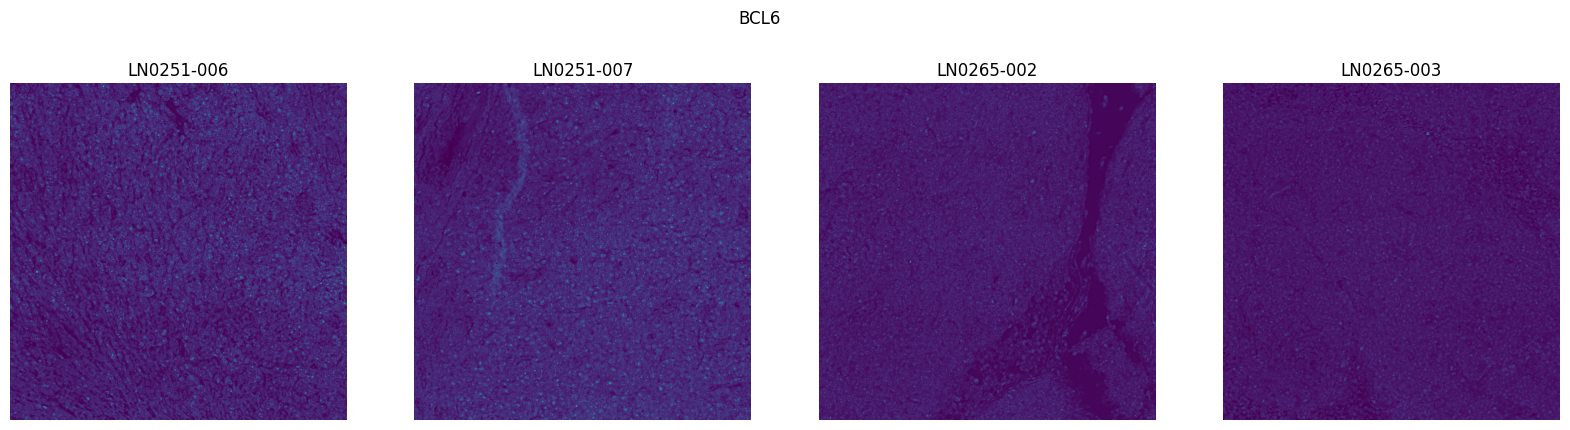

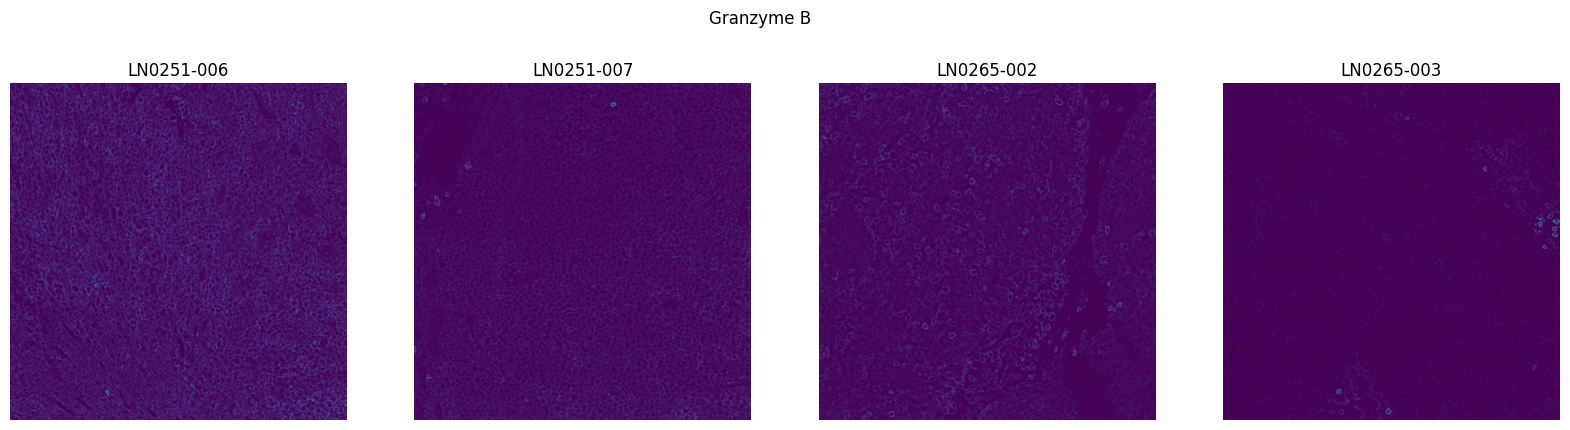

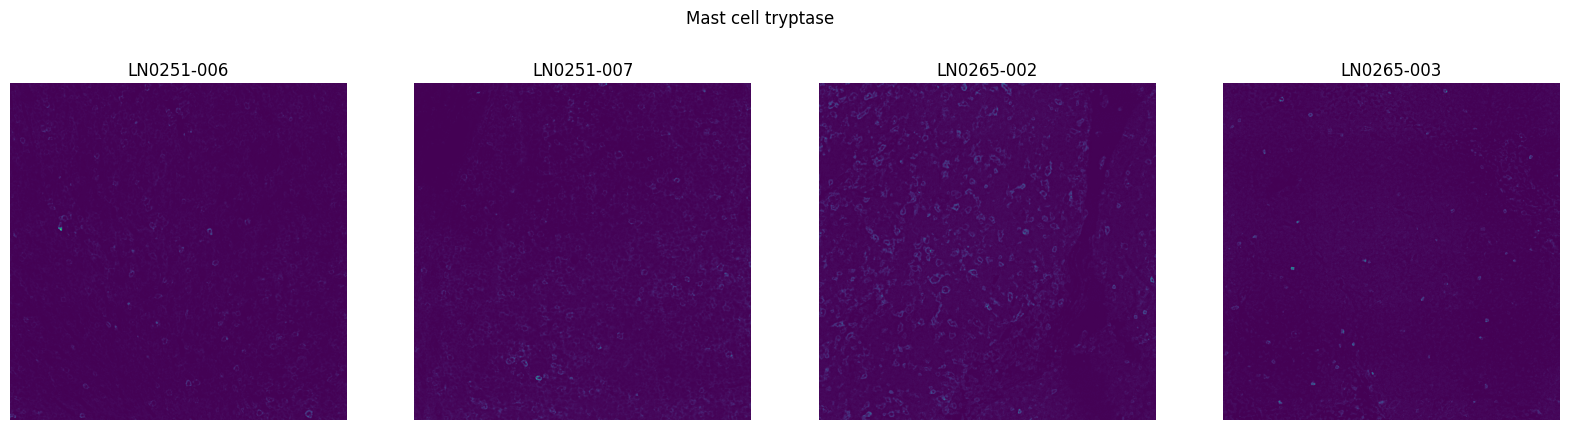

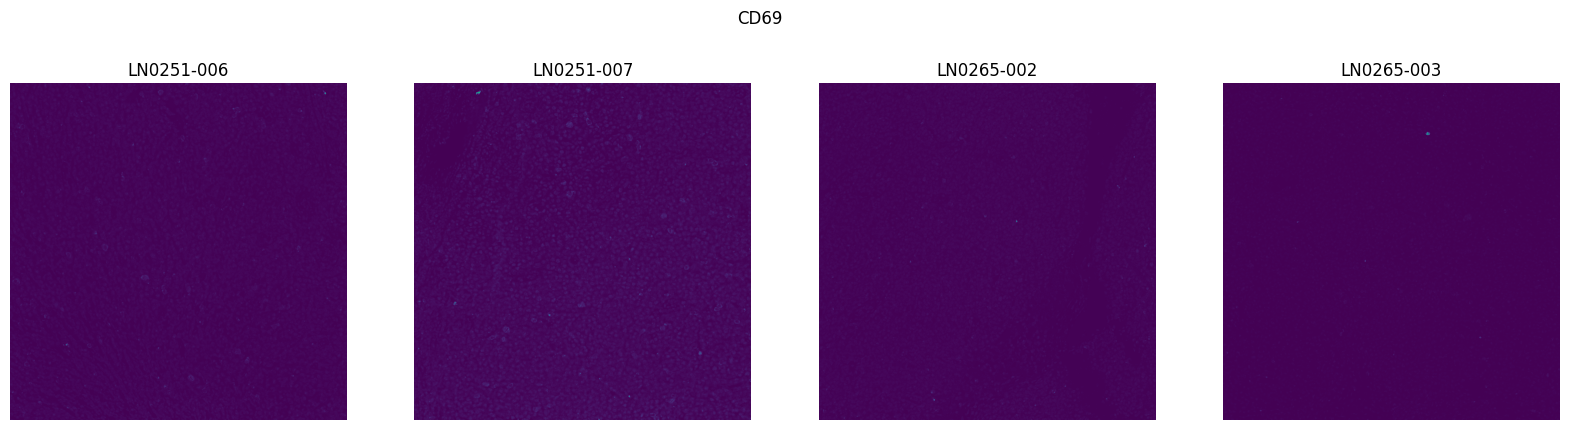

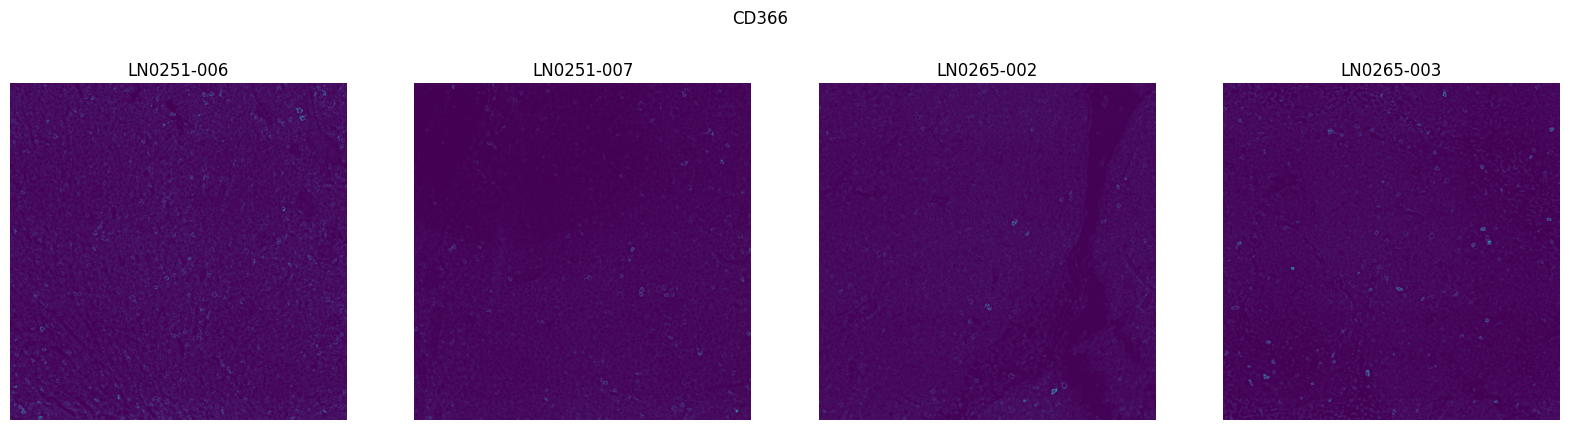

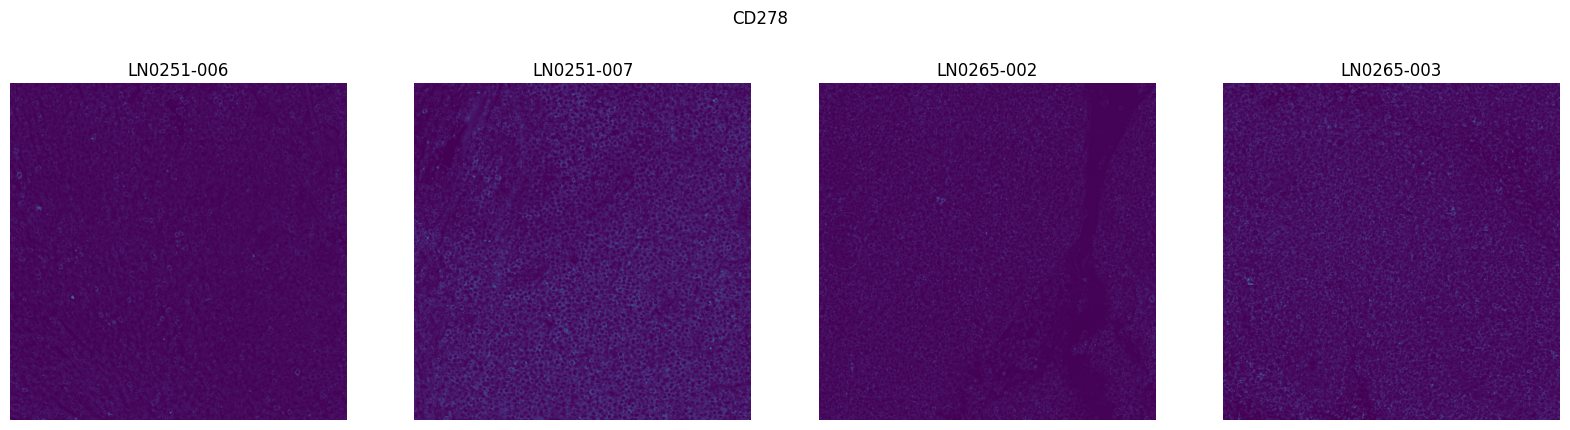

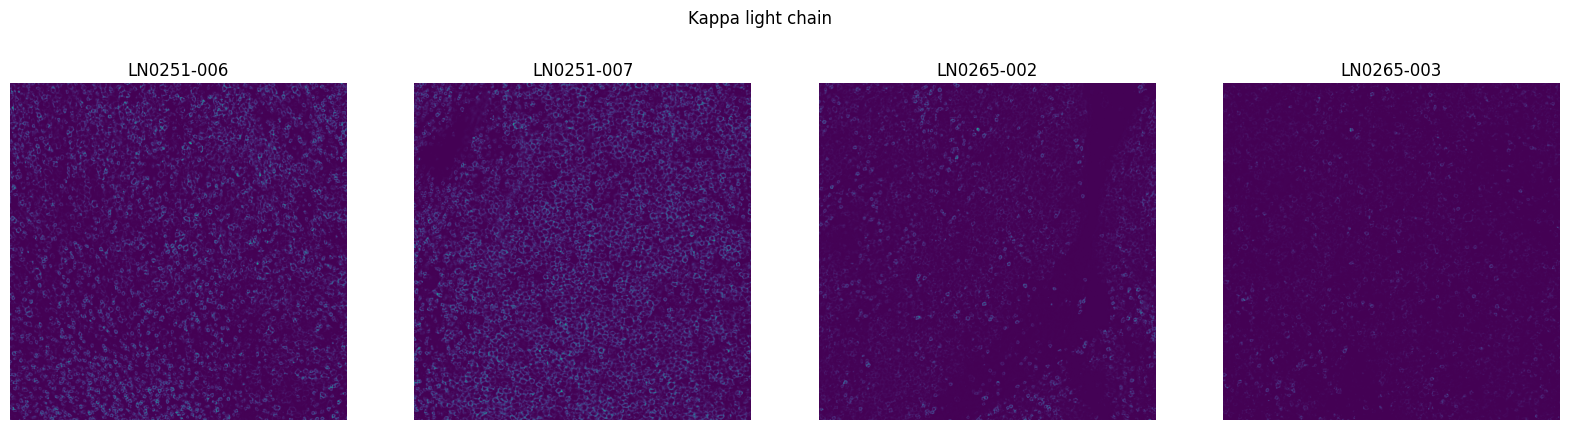

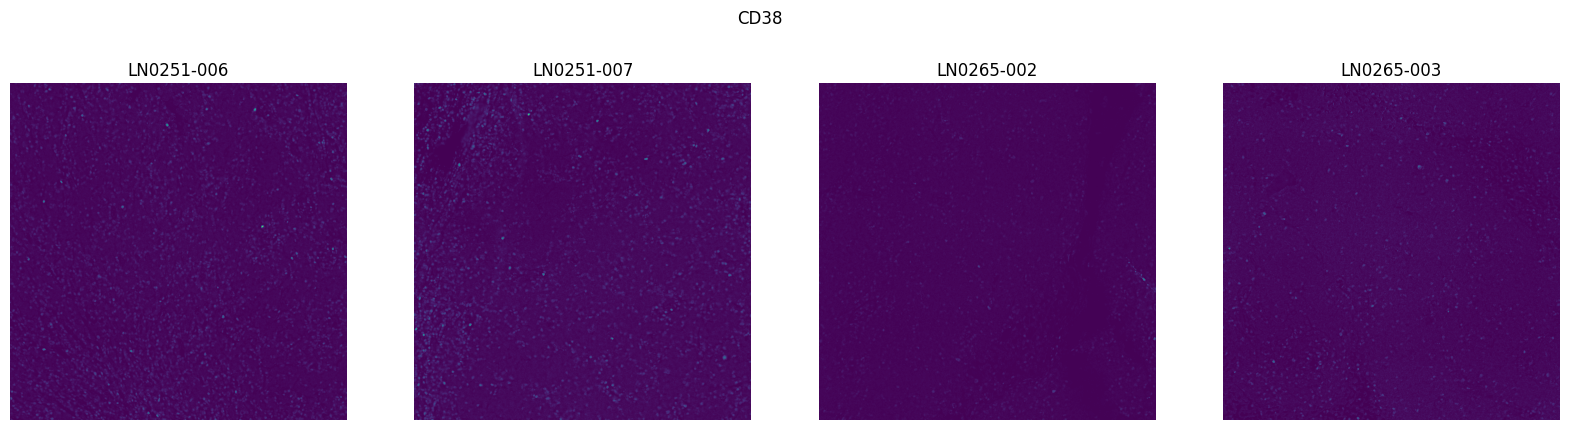

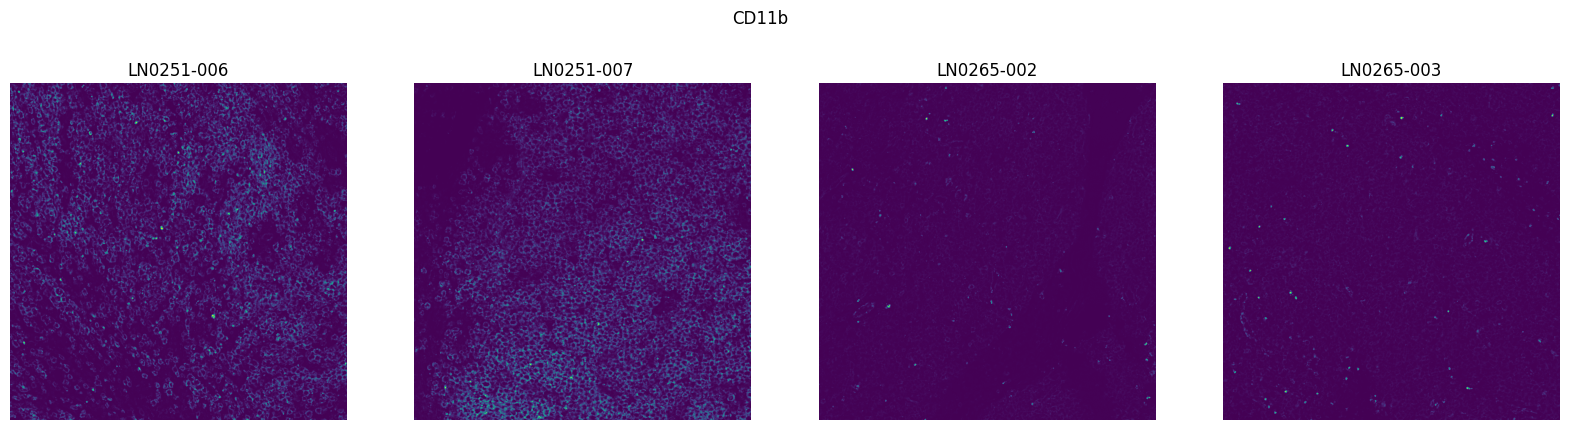

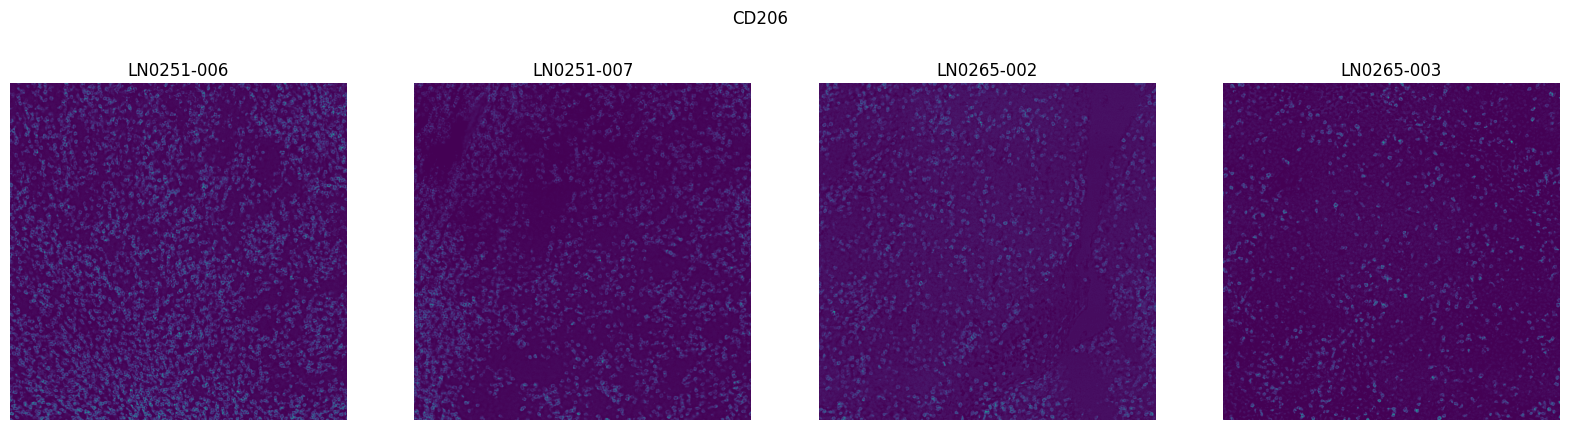

In [25]:
for idx in df_by_effect.head(10).index.tolist():
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    for i, sid in enumerate(sample_ids):
        ax[i].imshow(images[i][..., idx])
        ax[i].set_title(sid)
        ax[i].axis('off')
    fig.suptitle(df_by_effect.marker.iloc[idx])
        